In [34]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16,12)
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

np.random.seed(5)

In [35]:
time_steps = 3
n_features = 1
n_epochs = 100
DATASET = "papas_g2.csv"

In [36]:
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [37]:
data = pd.read_csv('../Data/'+DATASET, engine='python')


In [38]:
model = Sequential()
model.add(LSTM(4, input_shape=(time_steps, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

testSets = {}
crops = data['producto'].unique().tolist()
for crop in crops:
    cropData = data[data.producto == crop]["precio_mean"]

    dataset = cropData.values
    dataset = dataset.astype('float32')

    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(dataset.reshape(-1, 1))

    train = dataset[0:int(dataset.shape[0]*0.8), :]
    test = dataset[int(dataset.shape[0]*0.8):len(dataset), :]

    trainX, trainY = create_dataset(train, time_steps)
    testX, testY = create_dataset(test, time_steps)

    trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
    testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

    model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

    testSets[crop] = {'trainX': trainX, 'trainY': trainY,
                      'testX': testX, 'testY': testY, 'scaler': scaler}


Epoch 1/100
76/76 - 3s - loss: 0.1978 - 3s/epoch - 35ms/step
Epoch 2/100
76/76 - 0s - loss: 0.1250 - 88ms/epoch - 1ms/step
Epoch 3/100
76/76 - 0s - loss: 0.0838 - 95ms/epoch - 1ms/step
Epoch 4/100
76/76 - 0s - loss: 0.0642 - 120ms/epoch - 2ms/step
Epoch 5/100
76/76 - 0s - loss: 0.0584 - 138ms/epoch - 2ms/step
Epoch 6/100
76/76 - 0s - loss: 0.0555 - 126ms/epoch - 2ms/step
Epoch 7/100
76/76 - 0s - loss: 0.0534 - 102ms/epoch - 1ms/step
Epoch 8/100
76/76 - 0s - loss: 0.0509 - 85ms/epoch - 1ms/step
Epoch 9/100
76/76 - 0s - loss: 0.0489 - 86ms/epoch - 1ms/step
Epoch 10/100
76/76 - 0s - loss: 0.0473 - 86ms/epoch - 1ms/step
Epoch 11/100
76/76 - 0s - loss: 0.0452 - 85ms/epoch - 1ms/step
Epoch 12/100
76/76 - 0s - loss: 0.0437 - 86ms/epoch - 1ms/step
Epoch 13/100
76/76 - 0s - loss: 0.0429 - 83ms/epoch - 1ms/step
Epoch 14/100
76/76 - 0s - loss: 0.0412 - 86ms/epoch - 1ms/step
Epoch 15/100
76/76 - 0s - loss: 0.0399 - 84ms/epoch - 1ms/step
Epoch 16/100
76/76 - 0s - loss: 0.0400 - 94ms/epoch - 1ms/ste

1/1 [==============================] - 0s 15ms/step
PAPA BLANCA/VALLE/OTROS
Train Score: 0.15 MAPE
Test Score: 0.11 MAPE


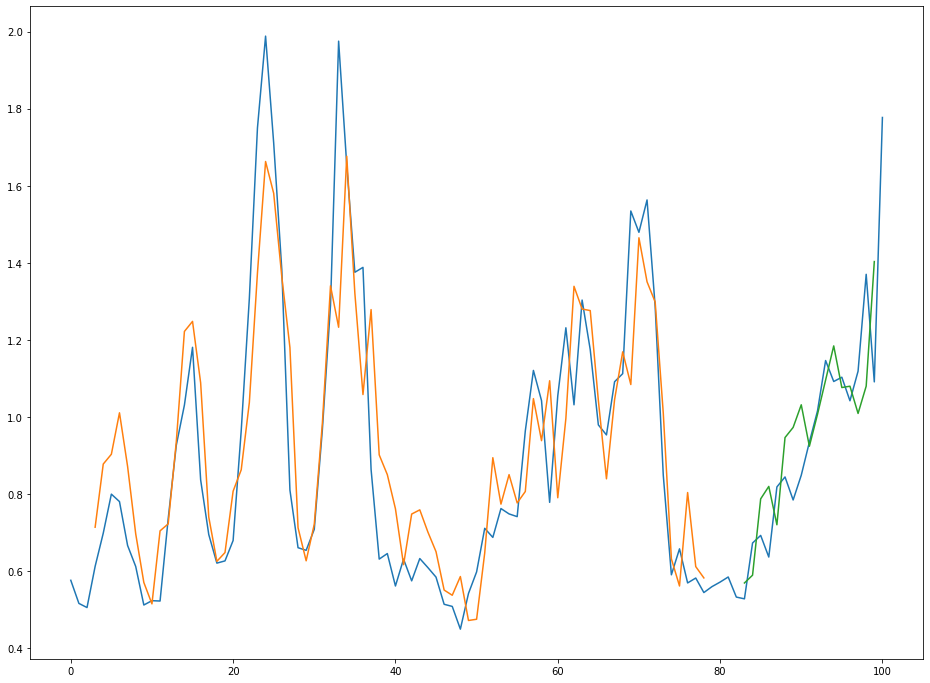

1/1 [==============================] - 0s 20ms/step
PAPA CANCHAN
Train Score: 0.12 MAPE
Test Score: 0.11 MAPE


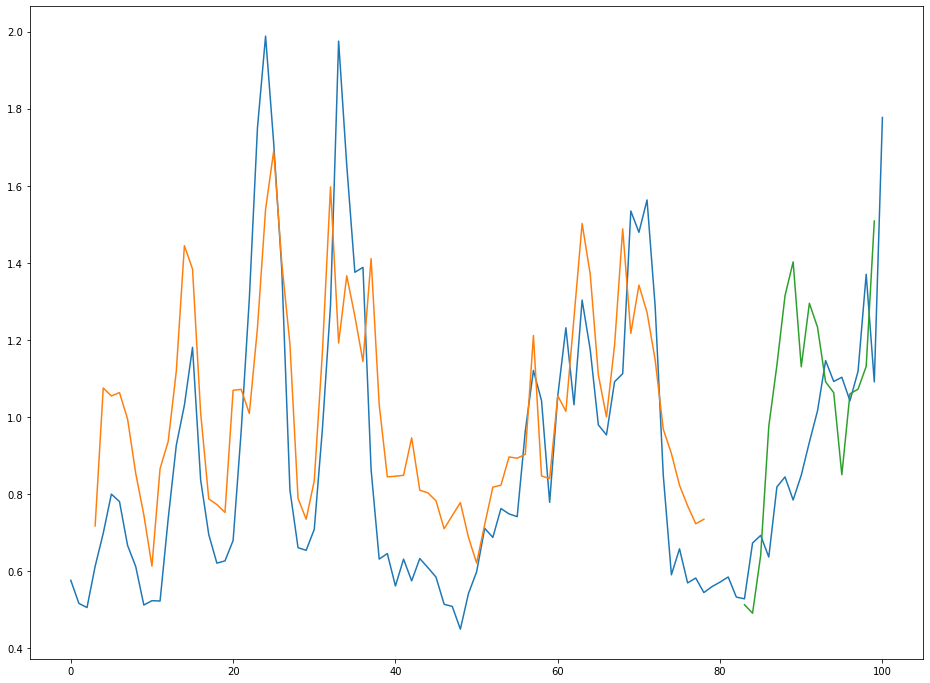

1/1 [==============================] - 0s 18ms/step
PAPA COLOR/VALLE/OTROS
Train Score: 0.13 MAPE
Test Score: 0.11 MAPE


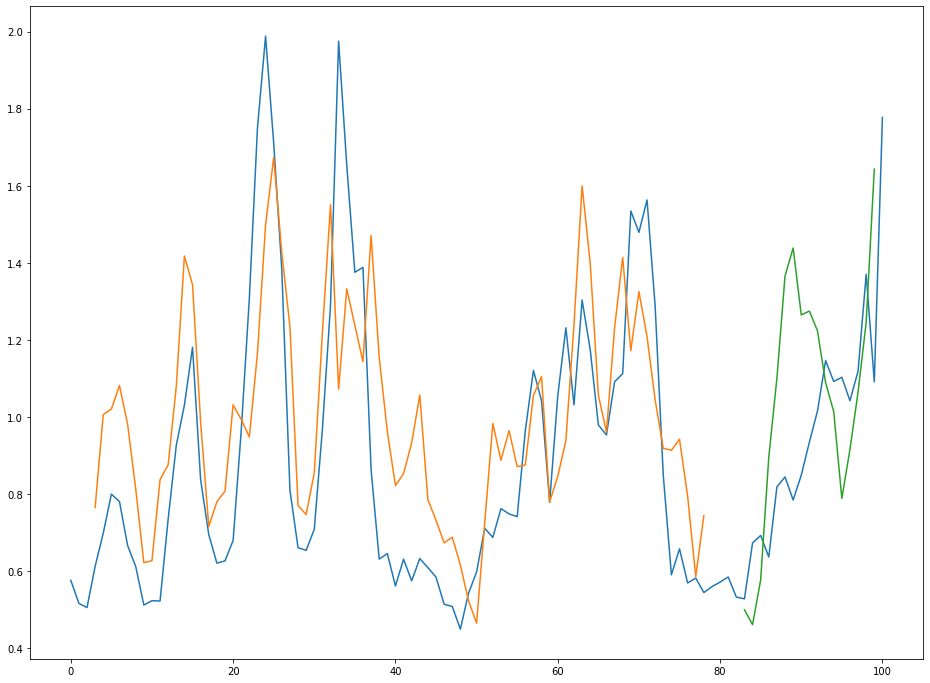

1/1 [==============================] - 0s 17ms/step
PAPA NEGRA ANDINA
Train Score: 0.12 MAPE
Test Score: 0.11 MAPE


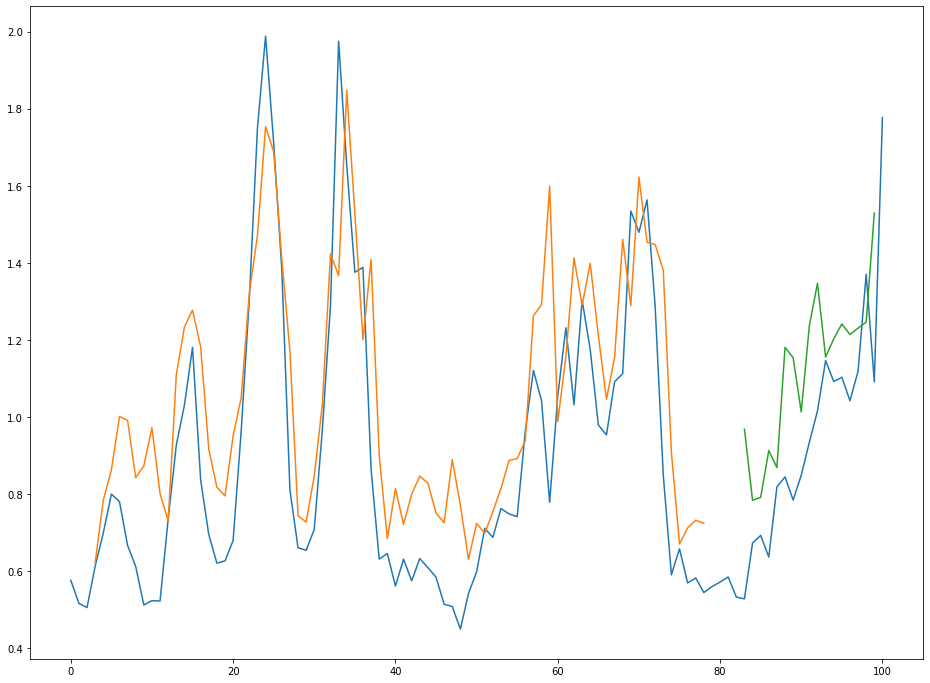

1/1 [==============================] - 0s 19ms/step
PAPA UNICA
Train Score: 0.15 MAPE
Test Score: 0.12 MAPE


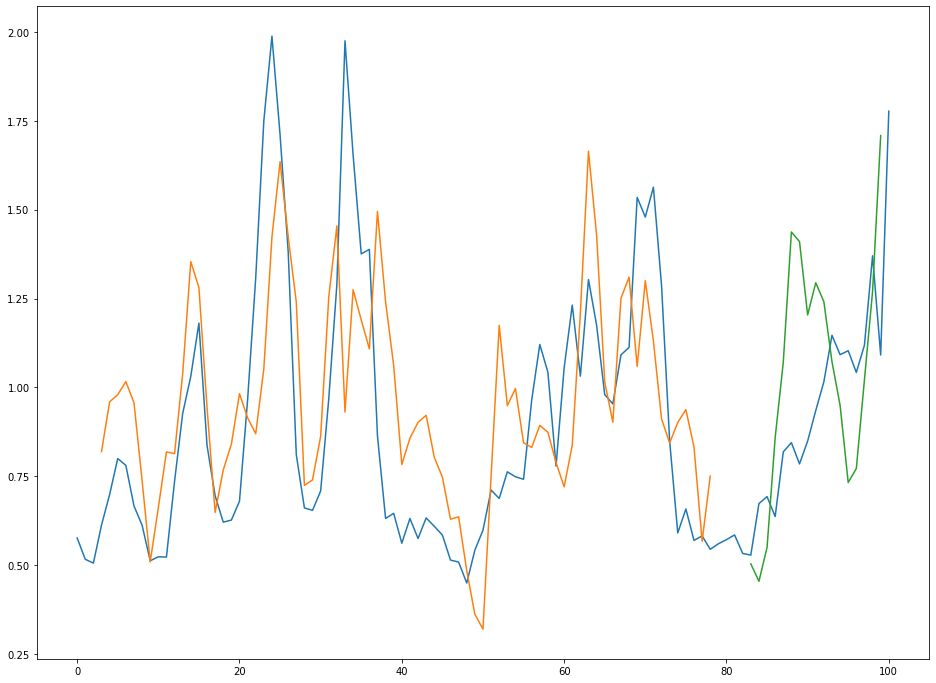

1/1 [==============================] - 0s 23ms/step
PAPA YUNGAY
Train Score: 0.15 MAPE
Test Score: 0.12 MAPE


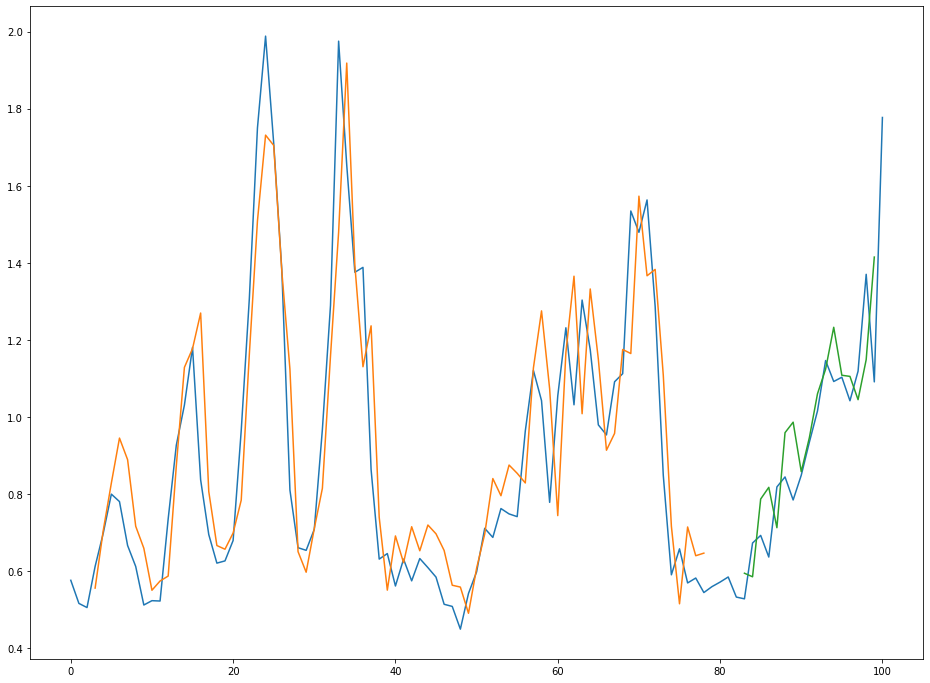

In [39]:
for crop in testSets:
    trainPredict = model.predict(testSets[crop]['trainX'])
    testPredict = model.predict(testSets[crop]['testX'])

    trainPredict = testSets[crop]['scaler'].inverse_transform(trainPredict)
    trainY = testSets[crop]['scaler'].inverse_transform([testSets[crop]['trainY']])
    testPredict = testSets[crop]['scaler'].inverse_transform(testPredict)
    testY = testSets[crop]['scaler'].inverse_transform([testSets[crop]['testY']])

    print(crop)
    trainScore = mean_absolute_percentage_error(trainY[0], trainPredict[:,0])
    print('Train Score: %.2f MAPE' % (trainScore))
    testScore = mean_absolute_percentage_error(testY[0], testPredict[:,0])
    print('Test Score: %.2f MAPE' % (testScore))

    trainPredictPlot = np.empty_like(dataset)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[time_steps:len(trainPredict)+time_steps, :] = trainPredict

    testPredictPlot = np.empty_like(dataset)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(trainPredict)+(time_steps*2)+1:len(dataset)-1, :] = testPredict

    plt.plot(scaler.inverse_transform(dataset))
    plt.plot(trainPredictPlot)
    plt.plot(testPredictPlot)
    plt.show()

In [40]:
a = {'a': {'a': 'a', 'b': 'b'}, 'b': {'a': 'a', 'b': 'b'}}
for x in a:
    print(a[x]['b'])


b
b
